In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le



/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
# [p241,p226] = modules.build_patients(-2, 90)
# pat_list = [p241,p226]
#p241 = modules.build_patients(241, 90)
#p231 = modules.build_patients(231, 90)
# p231, p222_1, p222_2, p229 = modules.build_patients(-1,90, if_weekly = 1)
# pat_list = [p231, p222_1, p222_2, p229]
# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')

p231, p222_1, p222_2, p241 = modules.build_patients(-3,90, if_weekly = 0, if_2weekly = 0)
pat_list = [p231, p222_1, p222_2, p241]

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [3]:
#plot_funcs.plot_epoch_mean(pat_list, if_save = 1, label = '')


In [2]:
def parameter_tuning(pat, X_train, X_test, y_train, y_test, classifier, C_range_num = 30, if_save = 0,
                     nfold = 10, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    

    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score for validations set: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
    
    if if_save:
        pat.result[classifier] = df
        pat.estimator[classifier] = clf_best
        pat.score[classifier] = clf_grid.best_score_
        pat.params[classifier] = clf_grid.best_params_



In [3]:
# X_train, X_test, y_train, y_test = modules.get_ml_data(p2, if_remove_icd = 1, if_remove_sleep=1, if_remove_le=0, le_class = 1)
# parameter_tuning(p229,X_train, X_test, y_train, y_test,1, C_range_num = 100, 
#                      nfold = 10, if_save = 0, if_show = 1)

In [4]:
def parameter_tuning_all(pat, C_range_num, label = '', if_scaler = 1, if_remove_icd = 1, if_remove_sleep=1, if_remove_le = 1, le_class = None, sleep_class =None, if_save = 1, if_show = 0, if_remove_delta = 1, if_remove_outliers = 0, if_split = 0, random_state = 42):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd, if_remove_sleep = if_remove_sleep, if_remove_le = if_remove_le, sleep_class = sleep_class, le_class = le_class, if_remove_delta = if_remove_delta, if_remove_outliers = if_remove_outliers, if_split = if_split, random_state =random_state)
    train_para = {}
    train_para['if_scaler'], train_para['if_remove_icd'], train_para['if_remove_sleep'], train_para['if_remove_le'] \
    , train_para['le_class'], train_para['if_remove_delta'], train_para['if_remove_outliers'], train_para['random_state'] = \
    if_scaler, if_remove_icd, if_remove_sleep, if_remove_le, le_class, if_remove_delta, if_remove_outliers, random_state
    pat.train_para = train_para
    pat.X_train, pat.X_test, pat.y_train, pat.y_test = X_train, X_test, y_train, y_test
    for classifier_int in tqdm.trange(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
        #save the best estimator
    JJ.scores_estimators(X_test, y_test, pat= pat, if_save = 0)
    if if_save:
        JJ.save_object(pat, hp.prepath_pat + pat.id + '_trained' + label + '.p')

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   18.1s finished
 14%|█▍        | 1/7 [00:18<01:48, 18.11s/it]

Best score for validations set: 0.8189189201475833
Best parameters: {'C': 0.22522747789389477, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.9s finished
 29%|██▊       | 2/7 [00:46<01:55, 23.01s/it]

Best score for validations set: 0.8178694894156541
Best parameters: {'C': 2.5475764809499513, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
 71%|███████▏  | 5/7 [00:49<00:19,  9.86s/it]

Best score for validations set: 0.7788855451295728
Best parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.3min finished
 86%|████████▌ | 6/7 [05:07<00:51, 51.22s/it]

Best score for validations set: 0.8348853173988119
Best parameters: {'max_depth': 14, 'min_samples_split': 25, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 26.5min finished
100%|██████████| 7/7 [31:39<00:00, 271.33s/it]

Best score for validations set: 0.8430029590023659
Best parameters: {'max_depth': 1, 'learning_rate': 0.005, 'subsample': 0.3, 'min_samples_leaf': 10}


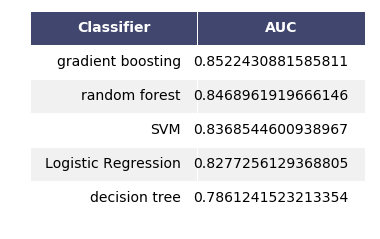

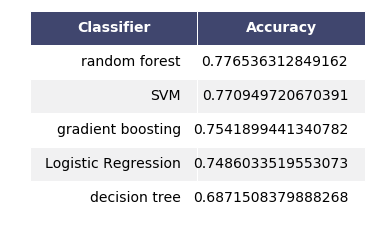

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.1s finished
 14%|█▍        | 1/7 [00:14<01:24, 14.12s/it]

Best score for validations set: 0.6932602864519184
Best parameters: {'C': 0.5060717571980283, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.7s finished
 29%|██▊       | 2/7 [00:37<01:34, 18.92s/it]

Best score for validations set: 0.6907523301768388
Best parameters: {'C': 3.6956562457834665, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.1s finished
 71%|███████▏  | 5/7 [00:40<00:16,  8.18s/it]

Best score for validations set: 0.626294998298423
Best parameters: {'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished
 86%|████████▌ | 6/7 [05:08<00:51, 51.35s/it]

Best score for validations set: 0.6859296844220907
Best parameters: {'max_depth': 12, 'min_samples_split': 25, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 24.7min finished
100%|██████████| 7/7 [29:49<00:00, 255.66s/it]

Best score for validations set: 0.6771221940035221
Best parameters: {'max_depth': 1, 'learning_rate': 0.005, 'subsample': 0.4, 'min_samples_leaf': 30}


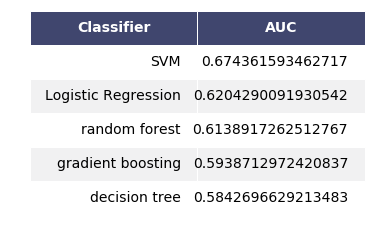

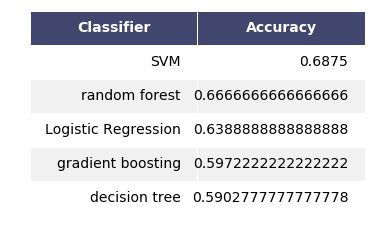

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.9s finished
 14%|█▍        | 1/7 [00:11<01:11, 11.95s/it]

Best score for validations set: 0.6961172681233492
Best parameters: {'C': 0.1863317091319726, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.4s finished
 29%|██▊       | 2/7 [00:30<01:16, 15.20s/it]

Best score for validations set: 0.7004797772885674
Best parameters: {'C': 0.8526431358305405, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished
 71%|███████▏  | 5/7 [00:33<00:13,  6.63s/it]

Best score for validations set: 0.6191583794548344
Best parameters: {'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.0min finished
 86%|████████▌ | 6/7 [04:32<00:45, 45.45s/it]

Best score for validations set: 0.6886327513962093
Best parameters: {'max_depth': 12, 'min_samples_split': 40, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.2min finished
100%|██████████| 7/7 [26:48<00:00, 229.84s/it]

Best score for validations set: 0.7046137356067562
Best parameters: {'max_depth': 2, 'learning_rate': 0.005, 'subsample': 0.3, 'min_samples_leaf': 20}


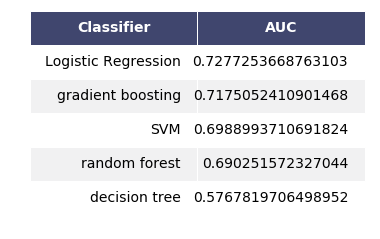

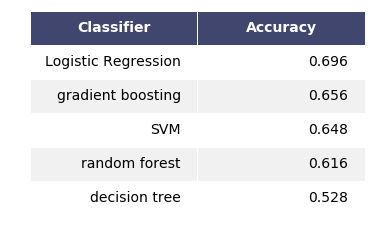

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   25.1s finished
 14%|█▍        | 1/7 [00:25<02:33, 25.52s/it]

Best score for validations set: 0.8168410788598492
Best parameters: {'C': 9.798909764568092, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   15.3s finished
 29%|██▊       | 2/7 [00:40<01:42, 20.43s/it]

Best score for validations set: 0.8096585467778725
Best parameters: {'C': 2.2049629919256972, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.4s finished
 71%|███████▏  | 5/7 [00:43<00:17,  8.66s/it]

Best score for validations set: 0.7156022009019518
Best parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.7min finished
 86%|████████▌ | 6/7 [04:27<00:44, 44.58s/it]

Best score for validations set: 0.7971478818059934
Best parameters: {'max_depth': 15, 'min_samples_split': 20, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 20.7min finished
100%|██████████| 7/7 [25:12<00:00, 216.07s/it]

Best score for validations set: 0.8166451916212498
Best parameters: {'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.3, 'min_samples_leaf': 20}


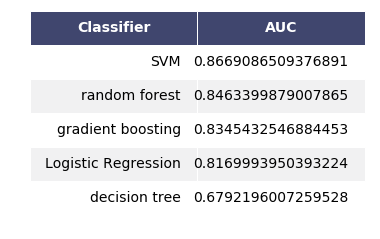

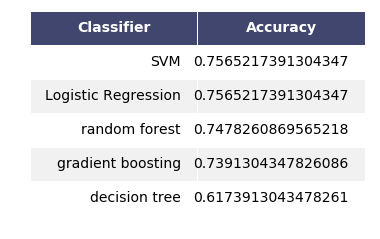

In [6]:
if_weekly = 0
if_2weekly = 0
if_split = 1
if if_weekly:
    label_w='_w'
elif if_2weekly:
    label_w = '_2w'
else:
    label_w = ''
p231, p222_1, p222_2, p241 = modules.build_patients(-3,90, if_weekly = if_weekly, if_2weekly = if_2weekly)
pat_list = [p231, p222_1, p222_2, p241]
rs = 77
label = '_ns_rs' + str(rs) + label_w
for pat in pat_list:
    parameter_tuning_all(pat, label = label, C_range_num = 100, if_save = 1, random_state = rs, if_split = if_split)


/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   16.9s finished
 14%|█▍        | 1/7 [00:16<01:41, 16.87s/it]

Best score for validations set: 0.8209337998765397
Best parameters: {'C': 0.30692597891615947, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   29.6s finished
 29%|██▊       | 2/7 [00:46<01:56, 23.24s/it]

Best score for validations set: 0.8182059779271239
Best parameters: {'C': 1.4191480919975707, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished
 71%|███████▏  | 5/7 [00:49<00:19,  9.96s/it]

Best score for validations set: 0.7783881729649892
Best parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.2min finished
 86%|████████▌ | 6/7 [05:02<00:50, 50.37s/it]

Best score for validations set: 0.8356125930725137
Best parameters: {'max_depth': 15, 'min_samples_split': 30, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.5min finished
100%|██████████| 7/7 [32:35<00:00, 279.30s/it]

Best score for validations set: 0.8472613183204317
Best parameters: {'max_depth': 3, 'learning_rate': 0.005, 'subsample': 0.4, 'min_samples_leaf': 30}


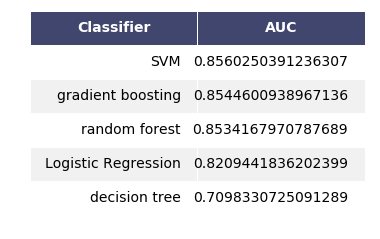

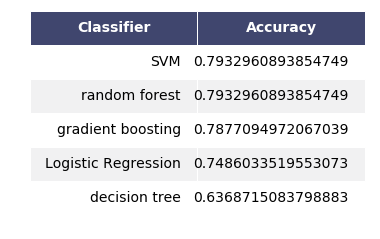

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.4s finished
 14%|█▍        | 1/7 [00:10<01:02, 10.44s/it]

Best score for validations set: 0.6711516087260578
Best parameters: {'C': 0.6291268887565918, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.7s finished
 29%|██▊       | 2/7 [00:34<01:25, 17.09s/it]

Best score for validations set: 0.6688690778736937
Best parameters: {'C': 0.7152239262703883, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
 71%|███████▏  | 5/7 [00:37<00:14,  7.47s/it]

Best score for validations set: 0.6088854129726673
Best parameters: {'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished
 86%|████████▌ | 6/7 [05:06<00:51, 51.06s/it]

Best score for validations set: 0.6609562923961375
Best parameters: {'max_depth': 15, 'min_samples_split': 20, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 24.9min finished
100%|██████████| 7/7 [29:59<00:00, 257.04s/it]

Best score for validations set: 0.6745556316915757
Best parameters: {'max_depth': 1, 'learning_rate': 0.005, 'subsample': 0.15, 'min_samples_leaf': 20}


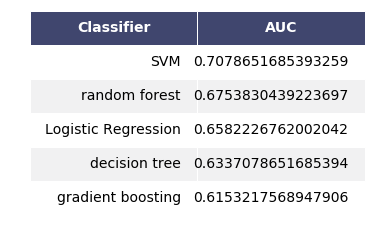

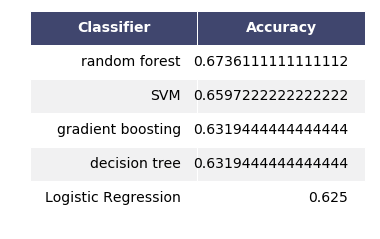

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   13.3s finished
 14%|█▍        | 1/7 [00:13<01:20, 13.36s/it]

Best score for validations set: 0.7087417857060591
Best parameters: {'C': 1.0019910282812088, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.4s finished
 29%|██▊       | 2/7 [00:31<01:19, 15.87s/it]

Best score for validations set: 0.7047971147549614
Best parameters: {'C': 1.8836141832460205, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished
 71%|███████▏  | 5/7 [00:34<00:13,  6.89s/it]

Best score for validations set: 0.6121349281635371
Best parameters: {'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.7min finished
 86%|████████▌ | 6/7 [04:17<00:42, 42.97s/it]

Best score for validations set: 0.6957338321964125
Best parameters: {'max_depth': 12, 'min_samples_split': 25, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 20.4min finished
100%|██████████| 7/7 [24:44<00:00, 212.08s/it]

Best score for validations set: 0.7153387982114401
Best parameters: {'max_depth': 2, 'learning_rate': 0.005, 'subsample': 0.2, 'min_samples_leaf': 10}


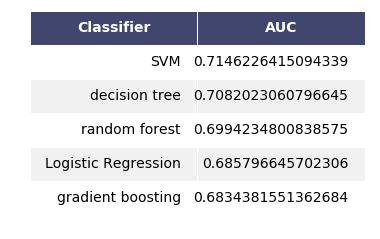

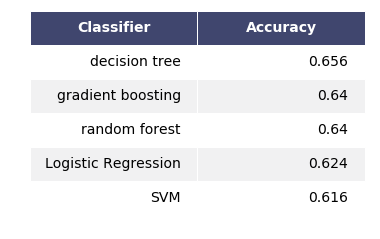

  0%|          | 0/7 [00:00<?, ?it/s]

epoch split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   25.1s finished
 14%|█▍        | 1/7 [00:25<02:31, 25.26s/it]

Best score for validations set: 0.8123052010238373
Best parameters: {'C': 8.787442694498653, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.3s finished
 29%|██▊       | 2/7 [00:38<01:36, 19.29s/it]

Best score for validations set: 0.8447180094374117
Best parameters: {'C': 4.24793347075216, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.1s finished
 71%|███████▏  | 5/7 [00:40<00:16,  8.15s/it]

Best score for validations set: 0.6949600390033257
Best parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished
 86%|████████▌ | 6/7 [03:58<00:39, 39.72s/it]

Best score for validations set: 0.799054517595027
Best parameters: {'max_depth': 13, 'min_samples_split': 20, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 19.6min finished
100%|██████████| 7/7 [23:32<00:00, 201.80s/it]

Best score for validations set: 0.8222910971426581
Best parameters: {'max_depth': 3, 'learning_rate': 0.02, 'subsample': 0.3, 'min_samples_leaf': 20}


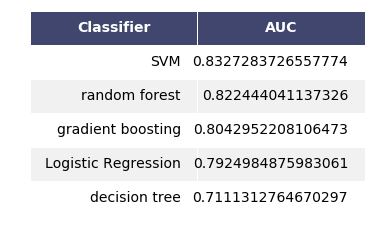

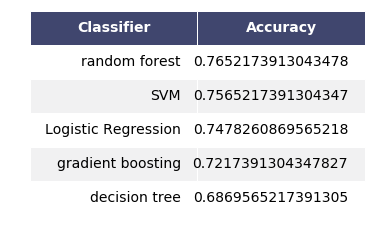

In [5]:
if_weekly = 0
if_2weekly = 0
if_split = 1
if if_weekly:
    label_w='_w'
elif if_2weekly:
    label_w = '_2w'
else:
    label_w = ''
p231, p222_1, p222_2, p241 = modules.build_patients(-3,90, if_weekly = if_weekly, if_2weekly = if_2weekly)
pat_list = [p231, p222_1, p222_2, p241]
rs = 11
label = '_ns_rs' + str(rs) + label_w
for pat in pat_list:
    parameter_tuning_all(pat, label = label, C_range_num = 100, if_save = 1, random_state = rs, if_split = if_split)




  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.8s finished


 14%|█▍        | 1/7 [00:14<01:28, 14.79s/it]

Best score for validations set: 0.8189277849605494
Best parameters: {'C': 0.269229490551873, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   26.6s finished


 29%|██▊       | 2/7 [00:41<01:43, 20.71s/it]

Best score for validations set: 0.8236935378267854
Best parameters: {'C': 3.397454659163014, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.0s finished


 71%|███████▏  | 5/7 [00:44<00:17,  8.90s/it]

Best score for validations set: 0.7693113198233049
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.2min finished


 86%|████████▌ | 6/7 [04:55<00:49, 49.23s/it]

Best score for validations set: 0.8408488094516073
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 25.3min finished


100%|██████████| 7/7 [30:17<00:00, 259.64s/it]



Best score for validations set: 0.8508843259303186
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.3, 'min_samples_leaf': 20}


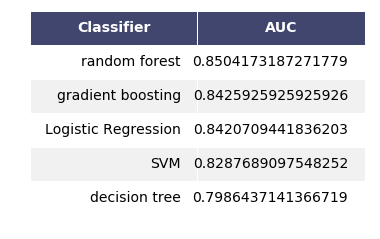

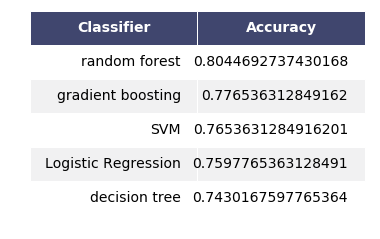



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.8s finished


 14%|█▍        | 1/7 [00:11<01:10, 11.79s/it]

Best score for validations set: 0.6659165472309
Best parameters: {'C': 0.7391251293369538, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.2s finished


 29%|██▊       | 2/7 [00:27<01:09, 13.99s/it]

Best score for validations set: 0.6824250082490703
Best parameters: {'C': 4.208720572557636, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.4s finished


 71%|███████▏  | 5/7 [00:30<00:12,  6.08s/it]

Best score for validations set: 0.6392978149162932
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.5min finished


 86%|████████▌ | 6/7 [04:01<00:40, 40.27s/it]

Best score for validations set: 0.6812717089650266
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 30}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 20.4min finished


100%|██████████| 7/7 [24:26<00:00, 209.44s/it]



Best score for validations set: 0.69559016525363
Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.3, 'min_samples_leaf': 10}


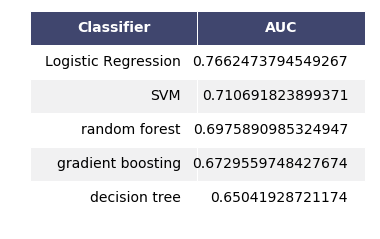

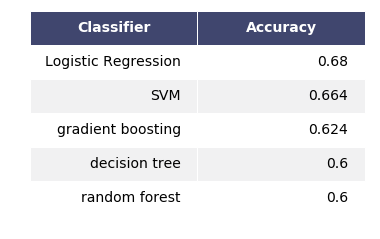



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   12.3s finished


 14%|█▍        | 1/7 [00:12<01:14, 12.34s/it]

Best score for validations set: 0.6837476815065341
Best parameters: {'C': 0.07380164596815834, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   20.9s finished


 29%|██▊       | 2/7 [00:33<01:23, 16.64s/it]

Best score for validations set: 0.6858567034497111
Best parameters: {'C': 1.7662958609039388, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished


 71%|███████▏  | 5/7 [00:36<00:14,  7.20s/it]

Best score for validations set: 0.6215689095843735
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.0min finished


 86%|████████▌ | 6/7 [04:35<00:45, 45.88s/it]

Best score for validations set: 0.6705330284442791
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 40}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.4min finished


100%|██████████| 7/7 [26:58<00:00, 231.25s/it]



Best score for validations set: 0.6668364556643355
Best parameters: {'learning_rate': 0.005, 'max_depth': 1, 'subsample': 0.4, 'min_samples_leaf': 10}


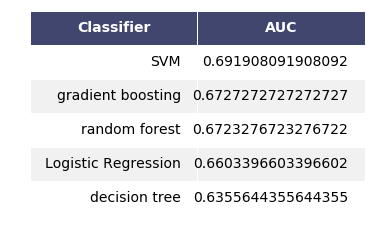

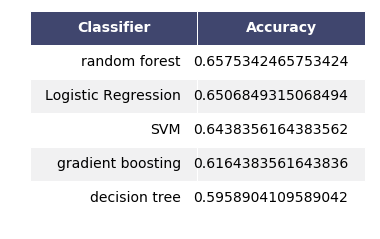



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   23.5s finished


 14%|█▍        | 1/7 [00:23<02:23, 23.88s/it]

Best score for validations set: 0.81166659427529
Best parameters: {'C': 8.235010633364325, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.1s finished


 29%|██▊       | 2/7 [00:36<01:32, 18.49s/it]

Best score for validations set: 0.8610867393476089
Best parameters: {'C': 6.2692632313541985, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.0s finished


 71%|███████▏  | 5/7 [00:39<00:15,  7.81s/it]

Best score for validations set: 0.7242865829822351
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished


 86%|████████▌ | 6/7 [03:55<00:39, 39.33s/it]

Best score for validations set: 0.8084915084915085
Best parameters: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 19.5min finished


100%|██████████| 7/7 [23:26<00:00, 200.96s/it]



Best score for validations set: 0.8312426703731052
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.3, 'min_samples_leaf': 20}


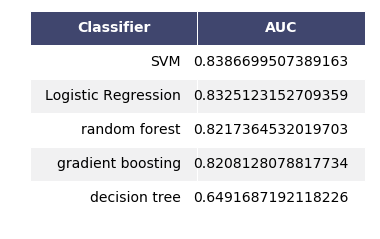

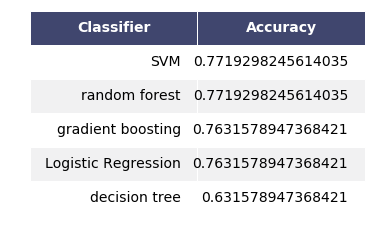

In [14]:
rs = 93
label = '_rs' + str(rs)
parameter_tuning_all(p231, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p222_2, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p222_1, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p241, label = label, C_range_num = 100, if_save = 1, random_state = rs)



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   16.4s finished


 14%|█▍        | 1/7 [00:16<01:38, 16.45s/it]

Best score for validations set: 0.8299032925118724
Best parameters: {'C': 0.4656825023875783, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   28.7s finished


 29%|██▊       | 2/7 [00:45<01:52, 22.59s/it]

Best score for validations set: 0.82711539574397
Best parameters: {'C': 2.059416632587754, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.4s finished


 71%|███████▏  | 5/7 [00:48<00:19,  9.72s/it]

Best score for validations set: 0.7823035990659296
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


 86%|████████▌ | 6/7 [05:19<00:53, 53.24s/it]

Best score for validations set: 0.8340824300851054
Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.7min finished


100%|██████████| 7/7 [33:04<00:00, 283.54s/it]



Best score for validations set: 0.8452948273669265
Best parameters: {'learning_rate': 0.01, 'max_depth': 1, 'subsample': 0.3, 'min_samples_leaf': 30}


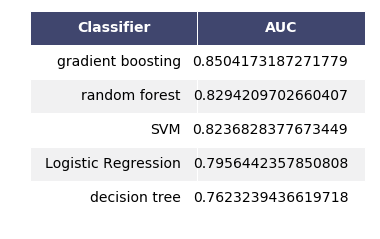

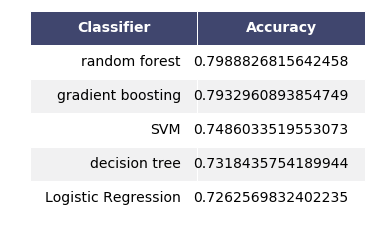



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.5s finished


 14%|█▍        | 1/7 [00:14<01:27, 14.53s/it]

Best score for validations set: 0.7130025837613426
Best parameters: {'C': 0.8643577126816886, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.1s finished


 29%|██▊       | 2/7 [00:33<01:24, 16.82s/it]

Best score for validations set: 0.7057954541715166
Best parameters: {'C': 1.7288394822207633, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.9s finished


 71%|███████▏  | 5/7 [00:36<00:14,  7.31s/it]

Best score for validations set: 0.6481797001975289
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.0min finished


 86%|████████▌ | 6/7 [04:37<00:46, 46.23s/it]

Best score for validations set: 0.7006864153744121
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.0min finished


100%|██████████| 7/7 [26:39<00:00, 228.44s/it]



Best score for validations set: 0.7120562965010482
Best parameters: {'learning_rate': 0.005, 'max_depth': 1, 'subsample': 0.2, 'min_samples_leaf': 10}


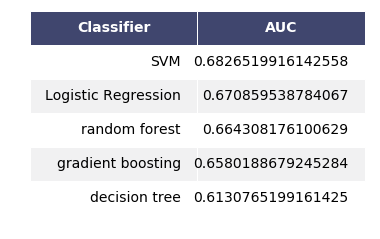

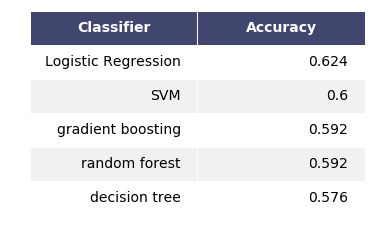



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.4s finished


 14%|█▍        | 1/7 [00:11<01:08, 11.43s/it]

Best score for validations set: 0.7039626674879924
Best parameters: {'C': 1.026958246142824, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   21.6s finished


 29%|██▊       | 2/7 [00:33<01:22, 16.51s/it]

Best score for validations set: 0.7317225950125995
Best parameters: {'C': 4.863340006567759, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished


 71%|███████▏  | 5/7 [00:36<00:14,  7.24s/it]

Best score for validations set: 0.6107276263876442
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished


 86%|████████▌ | 6/7 [04:59<00:49, 49.99s/it]

Best score for validations set: 0.6834713263444773
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 25}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 31.2min finished


100%|██████████| 7/7 [36:10<00:00, 310.07s/it]



Best score for validations set: 0.6766618346067024
Best parameters: {'learning_rate': 0.005, 'max_depth': 1, 'subsample': 0.15, 'min_samples_leaf': 10}


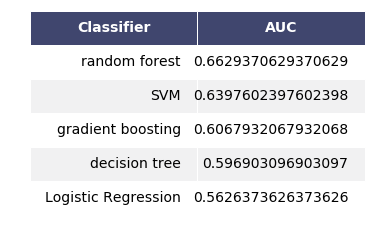

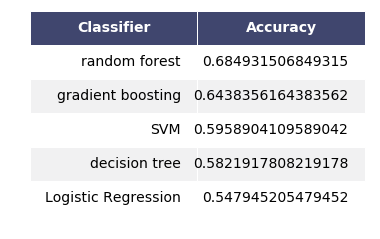



  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   15.4s finished


 14%|█▍        | 1/7 [00:15<01:32, 15.41s/it]

Best score for validations set: 0.7952221691352125
Best parameters: {'C': 2.116084546082586, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.3s finished


 29%|██▊       | 2/7 [00:28<01:11, 14.35s/it]

Best score for validations set: 0.7959040959040958
Best parameters: {'C': 1.380479263165598, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.1s finished


 71%|███████▏  | 5/7 [00:30<00:12,  6.16s/it]

Best score for validations set: 0.6820266689831906
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.2min finished


 86%|████████▌ | 6/7 [03:46<00:37, 37.79s/it]

Best score for validations set: 0.7873778395517526
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 19.5min finished


100%|██████████| 7/7 [23:17<00:00, 199.58s/it]



Best score for validations set: 0.8007340485601355
Best parameters: {'learning_rate': 0.005, 'max_depth': 2, 'subsample': 0.2, 'min_samples_leaf': 20}


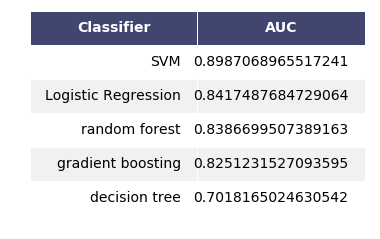

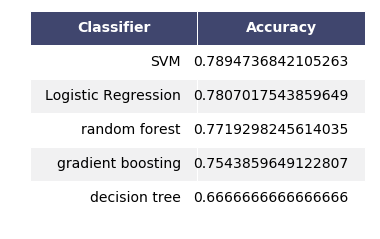

In [12]:
rs = 77
label = '_rs' + str(rs)
parameter_tuning_all(p231, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p222_2, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p222_1, label = label, C_range_num = 100, if_save = 1, random_state = rs)
parameter_tuning_all(p241, label = label, C_range_num = 100, if_save = 1, random_state = rs)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   12.4s finished
 14%|█▍        | 1/7 [00:12<01:14, 12.40s/it]

Best score for validations set: 0.6383831041377123
Best parameters: {'C': 1.0932861727612417, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.2s finished
 29%|██▊       | 2/7 [00:30<01:16, 15.32s/it]

Best score for validations set: 0.6472336515251261
Best parameters: {'kernel': 'rbf', 'C': 9.252905788717376, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished
 71%|███████▏  | 5/7 [00:33<00:13,  6.68s/it]

Best score for validations set: 0.5678714675834492
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.2min finished
 86%|████████▌ | 6/7 [04:48<00:48, 48.01s/it]

Best score for validations set: 0.6214203423304806
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 30}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.7min finished
100%|██████████| 7/7 [27:29<00:00, 235.64s/it]

Best score for validations set: 0.6400187135786214
Best parameters: {'subsample': 0.2, 'max_depth': 2, 'min_samples_leaf': 20, 'learning_rate': 0.02}


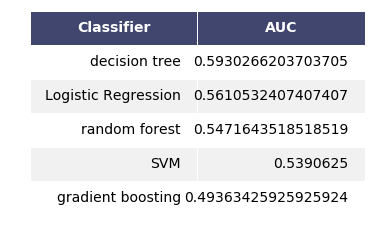

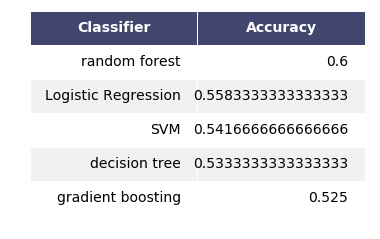

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.6s finished
 14%|█▍        | 1/7 [00:14<01:27, 14.58s/it]

Best score for validations set: 0.6615496839033879
Best parameters: {'C': 0.04696708986406989, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   24.4s finished
 29%|██▊       | 2/7 [00:39<01:37, 19.50s/it]

Best score for validations set: 0.7033948633291287
Best parameters: {'kernel': 'rbf', 'C': 2.0471667576316657, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
 71%|███████▏  | 5/7 [00:42<00:16,  8.43s/it]

Best score for validations set: 0.580300992044638
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished
 86%|████████▌ | 6/7 [05:32<00:55, 55.34s/it]

Best score for validations set: 0.6797965230925359
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 25}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 24.9min finished
100%|██████████| 7/7 [30:26<00:00, 260.88s/it]

Best score for validations set: 0.6819445764230868
Best parameters: {'subsample': 0.4, 'max_depth': 2, 'min_samples_leaf': 10, 'learning_rate': 0.005}


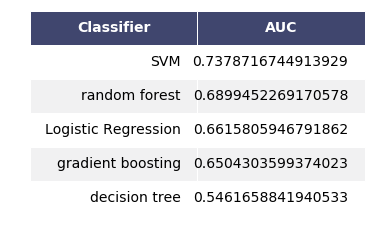

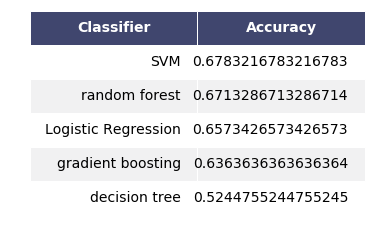

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.6s finished
 14%|█▍        | 1/7 [00:19<01:57, 19.66s/it]

Best score for validations set: 0.615317484084797
Best parameters: {'C': 0.039177681404430696, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   35.5s finished
 29%|██▊       | 2/7 [00:55<02:18, 27.61s/it]

Best score for validations set: 0.6143706528055559
Best parameters: {'kernel': 'rbf', 'C': 0.452270390378541, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.2s finished
 71%|███████▏  | 5/7 [00:59<00:23, 11.88s/it]

Best score for validations set: 0.5413763040840603
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.5min finished
 86%|████████▌ | 6/7 [06:31<01:05, 65.30s/it]

Best score for validations set: 0.6054520488038494
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 25}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.9min finished
100%|██████████| 7/7 [34:23<00:00, 294.82s/it]

Best score for validations set: 0.6197979241608051
Best parameters: {'subsample': 0.15, 'max_depth': 1, 'min_samples_leaf': 20, 'learning_rate': 0.02}


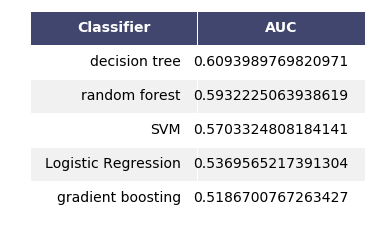

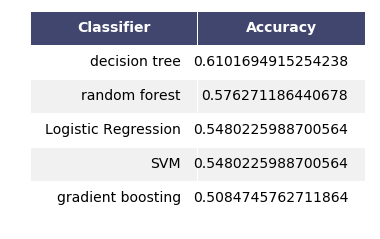

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.3s finished
 14%|█▍        | 1/7 [00:19<01:55, 19.30s/it]

Best score for validations set: 0.7093128022439856
Best parameters: {'C': 0.23388782788456985, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.6s finished
 29%|██▊       | 2/7 [00:32<01:22, 16.44s/it]

Best score for validations set: 0.7479498618283531
Best parameters: {'kernel': 'rbf', 'C': 8.269062534987489, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.2s finished
 71%|███████▏  | 5/7 [00:35<00:14,  7.02s/it]

Best score for validations set: 0.6971727683648212
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.6min finished
 86%|████████▌ | 6/7 [04:11<00:41, 41.99s/it]

Best score for validations set: 0.7594024133399313
Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 25}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.3min finished
100%|██████████| 7/7 [25:31<00:00, 218.80s/it]

Best score for validations set: 0.7638813581082514
Best parameters: {'subsample': 0.3, 'max_depth': 2, 'min_samples_leaf': 30, 'learning_rate': 0.005}


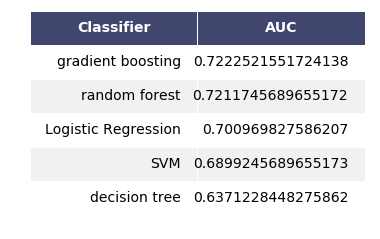

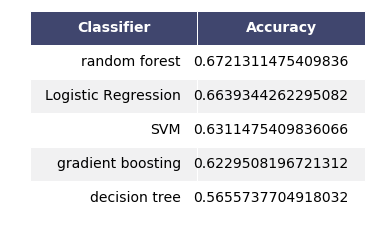

In [7]:
#label = '_split'
label = '_w'
if_split = 1
parameter_tuning_all(p222_2, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p222_1, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = label, if_split = if_split, C_range_num = 100, if_save = 1)

  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.6s finished
 14%|█▍        | 1/7 [00:14<01:27, 14.59s/it]

Best score for validations set: 0.8139609759969212
Best parameters: {'C': 0.42852808455445107, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.1s finished
 29%|██▊       | 2/7 [00:45<01:54, 22.88s/it]

Best score for validations set: 0.8185563185445256
Best parameters: {'C': 1.9860788488838332, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.8s finished
 71%|███████▏  | 5/7 [00:49<00:19,  9.93s/it]

Best score for validations set: 0.7412009243686781
Best parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished
 86%|████████▌ | 6/7 [05:41<00:56, 56.94s/it]

Best score for validations set: 0.8215070577816799
Best parameters: {'max_depth': 14, 'min_samples_split': 20, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.5min finished
100%|██████████| 7/7 [33:15<00:00, 285.06s/it]

Best score for validations set: 0.8394606572915185
Best parameters: {'max_depth': 2, 'learning_rate': 0.005, 'subsample': 0.4, 'min_samples_leaf': 30}


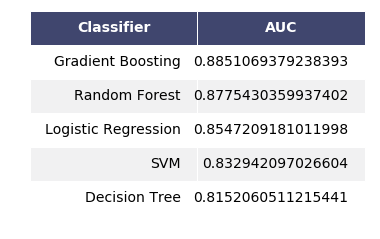

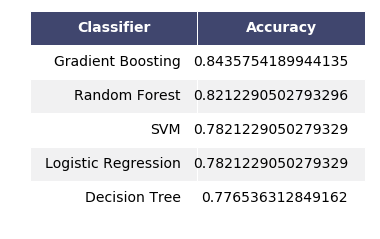

  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   16.6s finished
 14%|█▍        | 1/7 [00:16<01:39, 16.58s/it]

Best score for validations set: 0.817338336029413
Best parameters: {'C': 0.4303852485619112, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.8s finished
 29%|██▊       | 2/7 [00:44<01:51, 22.21s/it]

Best score for validations set: 0.8194414627652717
Best parameters: {'C': 2.4081275902910084, 'kernel': 'rbf', 'gamma': 0.04}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished
 71%|███████▏  | 5/7 [00:47<00:19,  9.54s/it]

Best score for validations set: 0.7404891119773223
Best parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.9min finished
 86%|████████▌ | 6/7 [05:40<00:56, 56.77s/it]

Best score for validations set: 0.82151015979768
Best parameters: {'max_depth': 14, 'min_samples_split': 20, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.5min finished
100%|██████████| 7/7 [33:09<00:00, 284.25s/it]

Best score for validations set: 0.8380919863267414
Best parameters: {'max_depth': 1, 'learning_rate': 0.01, 'subsample': 0.4, 'min_samples_leaf': 30}


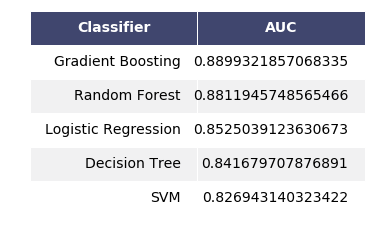

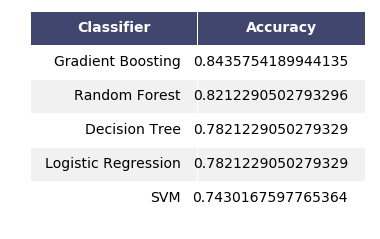

  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    6.2s finished
 14%|█▍        | 1/7 [00:06<00:37,  6.25s/it]

Best score for validations set: 0.8820510873142452
Best parameters: {'C': 0.30009153040341796, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.1s finished
 29%|██▊       | 2/7 [00:10<00:25,  5.17s/it]

Best score for validations set: 0.8637958532695376
Best parameters: {'C': 7.756731690830758, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished
 71%|███████▏  | 5/7 [00:11<00:04,  2.30s/it]

Best score for validations set: 0.7570871623503204
Best parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 10}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
 86%|████████▌ | 6/7 [02:39<00:26, 26.56s/it]

Best score for validations set: 0.8117794486215539
Best parameters: {'max_depth': 15, 'min_samples_split': 25, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 13.1min finished
100%|██████████| 7/7 [15:44<00:00, 134.89s/it]

Best score for validations set: 0.8321662742715376
Best parameters: {'max_depth': 1, 'learning_rate': 0.005, 'subsample': 0.4, 'min_samples_leaf': 10}


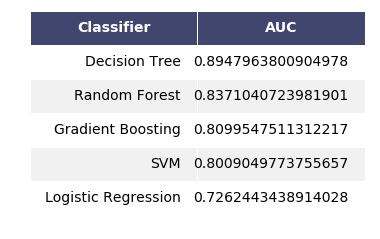

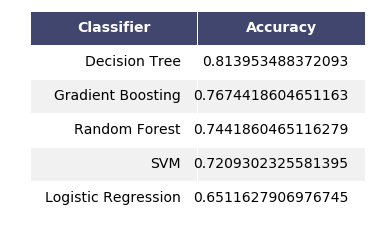

  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.1s finished
 14%|█▍        | 1/7 [00:17<01:42, 17.08s/it]

Best score for validations set: 0.8398990895537857
Best parameters: {'C': 0.5495421245336349, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.2s finished
 29%|██▊       | 2/7 [00:35<01:28, 17.67s/it]

Best score for validations set: 0.8421450595138441
Best parameters: {'C': 2.2030332995781676, 'kernel': 'rbf', 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished
 71%|███████▏  | 5/7 [00:37<00:15,  7.57s/it]

Best score for validations set: 0.7647984880374383
Best parameters: {'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.9min finished
 86%|████████▌ | 6/7 [04:33<00:45, 45.65s/it]

Best score for validations set: 0.8387859454848405
Best parameters: {'max_depth': 14, 'min_samples_split': 25, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.7min finished
100%|██████████| 7/7 [26:17<00:00, 225.41s/it]

Best score for validations set: 0.8595898806534166
Best parameters: {'max_depth': 2, 'learning_rate': 0.005, 'subsample': 0.15, 'min_samples_leaf': 20}


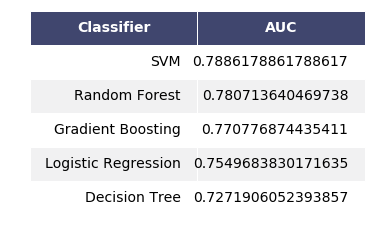

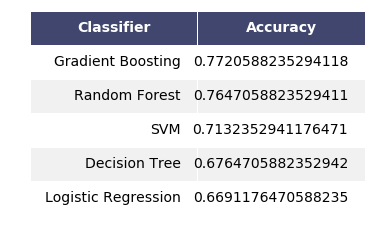

In [9]:
parameter_tuning_all(p231, label = '', C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = '_sleep', if_remove_sleep=0, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = '_sleep_sleep', sleep_class = 1, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = '_sleep_awake', sleep_class = 0, C_range_num = 100, if_save = 1)


  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   13.2s finished

 14%|█▍        | 1/7 [00:13<01:19, 13.22s/it]

Best score for validations set: 0.7187260025349999
Best parameters: {'C': 0.17982549990359464, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.9s finished

 29%|██▊       | 2/7 [00:30<01:15, 15.07s/it]

Best score for validations set: 0.7147401984144435
Best parameters: {'kernel': 'rbf', 'C': 5.638797936635185, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished

 71%|███████▏  | 5/7 [00:32<00:13,  6.53s/it]

Best score for validations set: 0.6415319817123424
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.0min finished

 86%|████████▌ | 6/7 [04:32<00:45, 45.42s/it]

Best score for validations set: 0.7074368919956646
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.8min finished

100%|██████████| 7/7 [26:22<00:00, 226.11s/it]


Best score for validations set: 0.732607699351532
Best parameters: {'subsample': 0.2, 'max_depth': 1, 'min_samples_leaf': 10, 'learning_rate': 0.01}


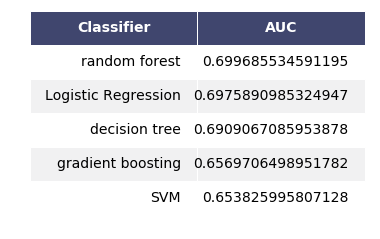

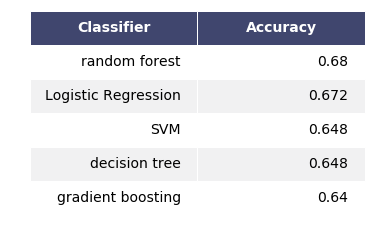


  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.0s finished

 14%|█▍        | 1/7 [00:13<01:23, 13.98s/it]

Best score for validations set: 0.6594353052779768
Best parameters: {'C': 0.05810287567039303, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.3s finished

 29%|██▊       | 2/7 [00:37<01:33, 18.65s/it]

Best score for validations set: 0.6675104059684965
Best parameters: {'kernel': 'rbf', 'C': 5.405465164536915, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.0s finished

 71%|███████▏  | 5/7 [00:40<00:16,  8.07s/it]

Best score for validations set: 0.6498224391825915
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished

 86%|████████▌ | 6/7 [05:05<00:50, 50.99s/it]

Best score for validations set: 0.6547374714676374
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 24.6min finished

100%|██████████| 7/7 [29:41<00:00, 254.53s/it]


Best score for validations set: 0.6411385969319632
Best parameters: {'subsample': 0.4, 'max_depth': 1, 'min_samples_leaf': 30, 'learning_rate': 0.005}


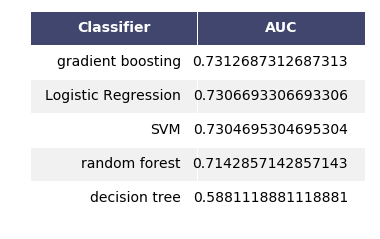

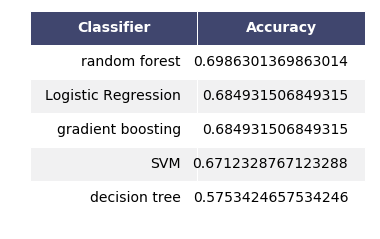


  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.1s finished

 14%|█▍        | 1/7 [00:17<01:42, 17.10s/it]

Best score for validations set: 0.8140418423450643
Best parameters: {'C': 0.4281949000787743, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   33.9s finished

 29%|██▊       | 2/7 [00:51<02:07, 25.52s/it]

Best score for validations set: 0.8188014179208172
Best parameters: {'kernel': 'rbf', 'C': 1.910173570972288, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.9s finished

 71%|███████▏  | 5/7 [00:55<00:22, 11.19s/it]

Best score for validations set: 0.7432516043038441
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.5min finished

 86%|████████▌ | 6/7 [06:26<01:04, 64.41s/it]

Best score for validations set: 0.8239245979065242
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 27.7min finished

100%|██████████| 7/7 [34:08<00:00, 292.67s/it]


Best score for validations set: 0.8387322584740926
Best parameters: {'subsample': 0.3, 'max_depth': 2, 'min_samples_leaf': 20, 'learning_rate': 0.005}


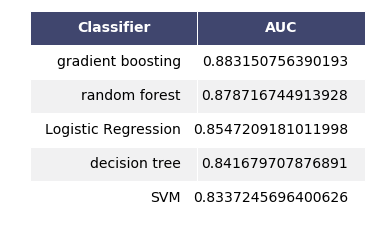

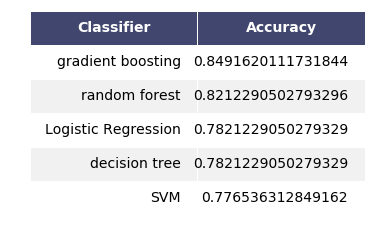


  0%|          | 0/7 [00:00<?, ?it/s]

not split
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   15.6s finished

 14%|█▍        | 1/7 [00:15<01:33, 15.60s/it]

Best score for validations set: 0.8034226642922294
Best parameters: {'C': 0.4374978727825228, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   15.5s finished

 29%|██▊       | 2/7 [00:31<01:17, 15.54s/it]

Best score for validations set: 0.8251270468661773
Best parameters: {'kernel': 'rbf', 'C': 5.515544352175713, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.6s finished

 71%|███████▏  | 5/7 [00:33<00:13,  6.74s/it]

Best score for validations set: 0.7255092733353602
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 60}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.8min finished

 86%|████████▌ | 6/7 [04:24<00:44, 44.07s/it]

Best score for validations set: 0.7969508752117448
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.8min finished

100%|██████████| 7/7 [26:15<00:00, 225.01s/it]


Best score for validations set: 0.8121574078095819
Best parameters: {'subsample': 0.4, 'max_depth': 3, 'min_samples_leaf': 30, 'learning_rate': 0.005}


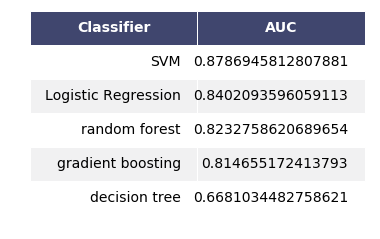

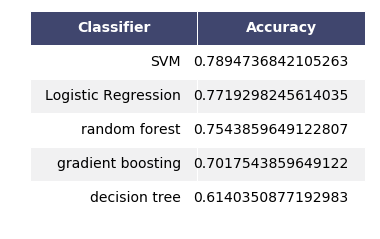

In [13]:
label = '_90_nd'
parameter_tuning_all(p222_2, label = label, C_range_num = 100, if_save = 1)
parameter_tuning_all(p222_1, label = label, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = label, C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = label, C_range_num = 100, if_save = 1)


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.3s finished

 14%|█▍        | 1/7 [00:14<01:26, 14.40s/it]

Best score for validations set: 0.6183984346426742
Best parameters: {'C': 6.535343388104662, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.0s finished

 29%|██▊       | 2/7 [00:31<01:18, 15.73s/it]

Best score for validations set: 0.6339910516177797
Best parameters: {'kernel': 'rbf', 'C': 1.6876283895658653, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished

 71%|███████▏  | 5/7 [00:34<00:13,  6.84s/it]

Best score for validations set: 0.563887898349304
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.9min finished

 86%|████████▌ | 6/7 [04:32<00:45, 45.40s/it]

Best score for validations set: 0.6497322495306367
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 30}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 20.9min finished

100%|██████████| 7/7 [25:28<00:00, 218.36s/it]


Best score for validations set: 0.6586417721210348
Best parameters: {'subsample': 0.15, 'max_depth': 3, 'min_samples_leaf': 10, 'learning_rate': 0.005}


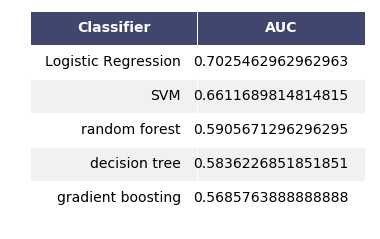

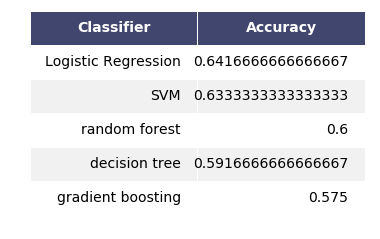


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   14.5s finished

 14%|█▍        | 1/7 [00:14<01:27, 14.54s/it]

Best score for validations set: 0.5595798793746262
Best parameters: {'C': 0.1349085872966712, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.3s finished

 29%|██▊       | 2/7 [00:37<01:34, 18.93s/it]

Best score for validations set: 0.592905138720422
Best parameters: {'kernel': 'rbf', 'C': 6.117367402205602, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.4s finished

 71%|███████▏  | 5/7 [00:41<00:16,  8.25s/it]

Best score for validations set: 0.5355145831741825
Best parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished

 86%|████████▌ | 6/7 [05:09<00:51, 51.58s/it]

Best score for validations set: 0.5592863588738403
Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'auto', 'min_samples_split': 25}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 22.6min finished

100%|██████████| 7/7 [27:49<00:00, 238.48s/it]


Best score for validations set: 0.5517781094323428
Best parameters: {'subsample': 0.4, 'max_depth': 1, 'min_samples_leaf': 10, 'learning_rate': 0.005}


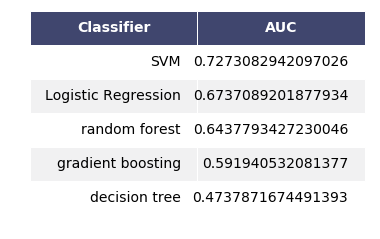

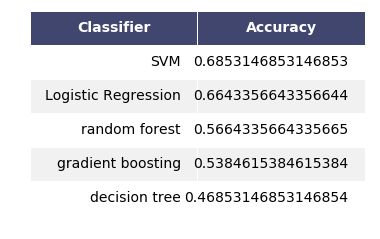


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.8s finished

 14%|█▍        | 1/7 [00:17<01:46, 17.80s/it]

Best score for validations set: 0.5806663707220036
Best parameters: {'C': 0.02602499877996305, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.0s finished

 29%|██▊       | 2/7 [00:49<02:04, 24.90s/it]

Best score for validations set: 0.5678598427555313
Best parameters: {'kernel': 'rbf', 'C': 1.1318739019648285, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.8s finished

 71%|███████▏  | 5/7 [00:53<00:21, 10.72s/it]

Best score for validations set: 0.5644849697700879
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 20}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.9min finished

 86%|████████▌ | 6/7 [05:51<00:58, 58.51s/it]

Best score for validations set: 0.6028356689691877
Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 25.6min finished

100%|██████████| 7/7 [31:28<00:00, 269.86s/it]


Best score for validations set: 0.6101251261195629
Best parameters: {'subsample': 0.3, 'max_depth': 2, 'min_samples_leaf': 30, 'learning_rate': 0.005}


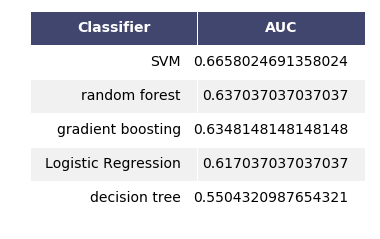

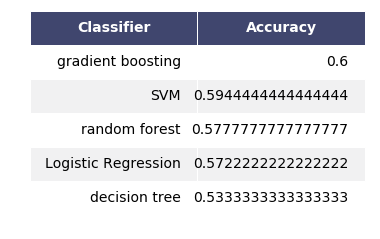


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   15.3s finished

 14%|█▍        | 1/7 [00:15<01:31, 15.28s/it]

Best score for validations set: 0.7856653225806451
Best parameters: {'C': 0.39312755141357825, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.0s finished

 29%|██▊       | 2/7 [00:28<01:10, 14.13s/it]

Best score for validations set: 0.8113049322113137
Best parameters: {'kernel': 'rbf', 'C': 2.023234330602982, 'gamma': 0.041666666666666664}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.0s finished

 71%|███████▏  | 5/7 [00:30<00:12,  6.06s/it]

Best score for validations set: 0.7692264200561011
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.2min finished

 86%|████████▌ | 6/7 [03:43<00:37, 37.28s/it]

Best score for validations set: 0.8309914095371668
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 19.4min finished

100%|██████████| 7/7 [23:09<00:00, 198.49s/it]


Best score for validations set: 0.8496160589060309
Best parameters: {'subsample': 0.3, 'max_depth': 3, 'min_samples_leaf': 10, 'learning_rate': 0.005}


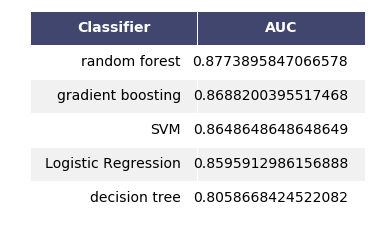

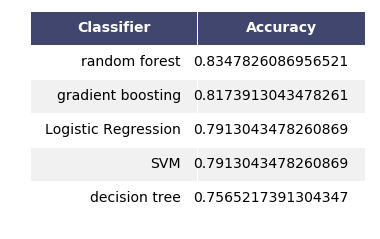

In [16]:
label = '_2w'
if_split = 1
parameter_tuning_all(p222_2, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p222_1, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p231, label = label, if_split = if_split, C_range_num = 100, if_save = 1)
parameter_tuning_all(p241, label = label, if_split = if_split, C_range_num = 100, if_save = 1)

In [12]:
parameter_tuning_all(p222_2, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.9s finished
 14%|█▍        | 1/7 [00:17<01:47, 17.90s/it]

Best score for validations set: 0.7245304162587004
Best parameters: {'C': 0.0414036743253537, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.8s finished
 29%|██▊       | 2/7 [00:37<01:34, 18.89s/it]

Best score for validations set: 0.7209469693230317
Best parameters: {'kernel': 'rbf', 'gamma': 0.034482758620689655, 'C': 2.445387187569815}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.9s finished
 71%|███████▏  | 5/7 [00:40<00:16,  8.13s/it]

Best score for validations set: 0.6403124954192607
Best parameters: {'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.3min finished
 86%|████████▌ | 6/7 [04:57<00:49, 49.51s/it]

Best score for validations set: 0.7101887010324576
Best parameters: {'criterion': 'entropy', 'min_samples_split': 25, 'max_depth': 13, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 21.8min finished
100%|██████████| 7/7 [26:43<00:00, 229.13s/it]

Best score for validations set: 0.7299002393501737
Best parameters: {'min_samples_leaf': 10, 'max_depth': 2, 'subsample': 0.2, 'learning_rate': 0.005}


In [36]:
parameter_tuning_all(p231, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)


  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 21
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.9s finished

 14%|█▍        | 1/7 [00:19<01:59, 19.93s/it]

Best score for validations set: 0.8284493782971579
Best parameters: {'penalty': 'l1', 'C': 0.9087943416819215}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.6s finished

 29%|██▊       | 2/7 [00:52<02:11, 26.27s/it]

Best score for validations set: 0.8415822340569515
Best parameters: {'C': 3.5588807813816326, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.9s finished

 71%|███████▏  | 5/7 [00:56<00:22, 11.28s/it]

Best score for validations set: 0.8027130542877472
Best parameters: {'min_samples_split': 40, 'max_depth': 4, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.1min finished

 86%|████████▌ | 6/7 [06:01<01:00, 60.23s/it]

Best score for validations set: 0.8439371452196451
Best parameters: {'max_features': 'auto', 'min_samples_split': 20, 'max_depth': 13, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 29.1min finished

100%|██████████| 7/7 [35:08<00:00, 301.21s/it]


Best score for validations set: 0.8597971080824425
Best parameters: {'learning_rate': 0.01, 'subsample': 0.3, 'min_samples_leaf': 30, 'max_depth': 1}
